In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Using device: cuda
Train subset size: 2000
Test subset size: 200

--- Training VAE (Part 1) on small subset of Fashion-MNIST ---

Epoch [1/500] | Loss: 435.7031 | Time: 0.29s
Epoch [2/500] | Loss: 312.6313 | Time: 0.29s
Epoch [3/500] | Loss: 288.4855 | Time: 0.35s
Epoch [4/500] | Loss: 279.3130 | Time: 0.30s
Epoch [5/500] | Loss: 274.7247 | Time: 0.28s
Epoch [6/500] | Loss: 271.6310 | Time: 0.28s
Epoch [7/500] | Loss: 269.0718 | Time: 0.33s
Epoch [8/500] | Loss: 266.9108 | Time: 0.40s
Epoch [9/500] | Loss: 264.6256 | Time: 0.37s
Epoch [10/500] | Loss: 262.8277 | Time: 0.41s
Epoch [11/500] | Loss: 261.3703 | Time: 0.38s
Epoch [12/500] | Loss: 260.1434 | Time: 0.35s
Epoch [13/500] | Loss: 258.9762 | Time: 0.41s
Epoch [14/500] | Loss: 258.0622 | Time: 0.45s
Epoch [15/500] | Loss: 256.9546 | Time: 0.36s
Epoch [16/500] | Loss: 255.8708 | Time: 0.27s
Epoch [17/500] | Loss: 255.2072 | Time: 0.29s
Epoch [18/500] | Loss: 254.7848 | Time: 0.29s
Epoch [19/500] | Loss: 254.3728 | Time: 0.29s
Epoch

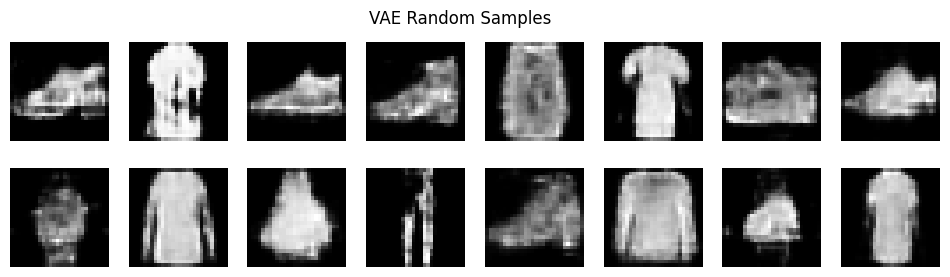


--- Training DCGAN (Part 2) on small subset of Fashion-MNIST ---

Epoch [1/200] | D Loss: 0.0207 | G Loss: 5.4611 | Time: 0.39s
Epoch [2/200] | D Loss: 0.0041 | G Loss: 6.4818 | Time: 0.36s
Epoch [3/200] | D Loss: 0.1062 | G Loss: 4.4683 | Time: 0.37s
Epoch [4/200] | D Loss: 0.2105 | G Loss: 5.7061 | Time: 0.38s
Epoch [5/200] | D Loss: 1.2176 | G Loss: 1.1490 | Time: 0.36s
Epoch [6/200] | D Loss: 1.1254 | G Loss: 0.9174 | Time: 0.37s
Epoch [7/200] | D Loss: 1.0829 | G Loss: 0.9414 | Time: 0.35s
Epoch [8/200] | D Loss: 1.1054 | G Loss: 1.3991 | Time: 0.36s
Epoch [9/200] | D Loss: 1.1408 | G Loss: 1.6739 | Time: 0.48s
Epoch [10/200] | D Loss: 0.9304 | G Loss: 1.0262 | Time: 0.45s
Epoch [11/200] | D Loss: 1.0685 | G Loss: 1.6690 | Time: 0.52s
Epoch [12/200] | D Loss: 0.9334 | G Loss: 1.2661 | Time: 0.46s
Epoch [13/200] | D Loss: 1.0854 | G Loss: 1.6898 | Time: 0.44s
Epoch [14/200] | D Loss: 0.9629 | G Loss: 1.0141 | Time: 0.56s
Epoch [15/200] | D Loss: 0.9580 | G Loss: 1.1352 | Time: 0.4

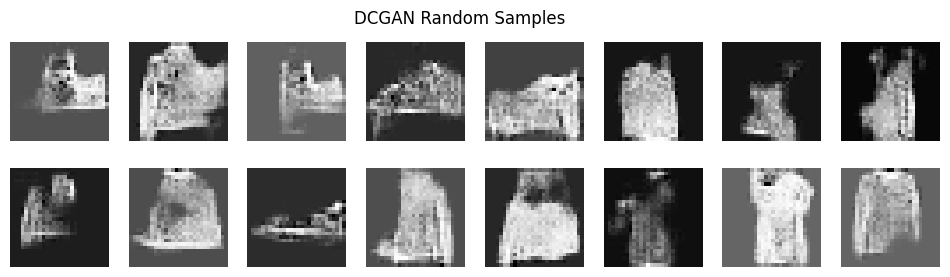

In [6]:
################################################################################
# CELL 1: IMPORTS & SETUP
################################################################################
#!pip install torchvision  # (If not installed)
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import time, copy, random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# We'll use Fashion-MNIST
# To keep it fast, let's take only a subset (e.g. 2000 train, 200 test)
NUM_TRAIN = 2000
NUM_TEST = 200

################################################################################
# CELL 2: DATA LOADING (Fashion-MNIST, SUBSET)
################################################################################
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load the full Fashion-MNIST
train_full = torchvision.datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_full  = torchvision.datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

# Shuffle indices to create a small subset
train_indices = list(range(len(train_full)))
random.shuffle(train_indices)
train_indices = train_indices[:NUM_TRAIN]

test_indices = list(range(len(test_full)))
random.shuffle(test_indices)
test_indices = test_indices[:NUM_TEST]

train_subset = Subset(train_full, train_indices)
test_subset  = Subset(test_full, test_indices)

batch_size = 64

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

print("Train subset size:", len(train_subset))
print("Test subset size:", len(test_subset))

################################################################################
# PART 1: VARIATIONAL AUTOENCODER (VAE)
################################################################################
"""
We'll build a small CNN-based VAE:

Encoder:
  - Conv2D -> Conv2D -> Flatten -> FC -> (mean, log_var)

Decoder:
  - FC -> Unflatten -> ConvTranspose2D -> output

We train for ~5 epochs for a quick demonstration.
"""

LATENT_DIM = 20  # dimension of latent space

class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super().__init__()
        # Encoder
        self.enc_conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # 1x28x28 -> 32x14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # 32x14x14 -> 64x7x7
            nn.ReLU()
        )
        self.fc_mu    = nn.Linear(64*7*7, latent_dim)
        self.fc_logvar= nn.Linear(64*7*7, latent_dim)

        # Decoder
        self.dec_fc = nn.Linear(latent_dim, 64*7*7)
        self.dec_deconv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), # 64x7x7 -> 32x14x14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # 32x14x14 -> 1x28x28
        )

    def encode(self, x):
        h = self.enc_conv(x)
        h = h.view(h.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # reparam trick
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h = self.dec_fc(z)
        h = h.view(h.size(0), 64, 7, 7)
        x_hat = self.dec_deconv(h)
        return x_hat  # no sigmoid -> we'll handle in the loss

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    # recon_x is logits, so use BCE with logits
    bce = nn.functional.binary_cross_entropy_with_logits(
        recon_x, x, reduction='sum'
    )
    # KLD = 0.5 * sum(1 + logvar - mu^2 - exp(logvar))
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return bce + kld

vae = VAE(LATENT_DIM).to(device)
optimizer_vae = optim.Adam(vae.parameters(), lr=1e-3)

print("\n--- Training VAE (Part 1) on small subset of Fashion-MNIST ---\n")

epochs_vae = 500
vae.train()
for epoch in range(epochs_vae):
    epoch_loss = 0.0
    start_time = time.time()
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        optimizer_vae.zero_grad()
        recon, mu, logvar = vae(imgs)
        loss = vae_loss(recon, imgs, mu, logvar)
        loss.backward()
        optimizer_vae.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{epochs_vae}] | Loss: {epoch_loss:.4f} | Time: {time.time()-start_time:.2f}s")

print("\n--- Evaluating VAE on test subset ---")
vae.eval()
test_loss = 0.0
with torch.no_grad():
    for imgs, _ in test_loader:
        imgs = imgs.to(device)
        recon, mu, logvar = vae(imgs)
        loss = vae_loss(recon, imgs, mu, logvar)
        test_loss += loss.item()
test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")

# Generate some images from random z
vae.eval()
with torch.no_grad():
    z = torch.randn(16, LATENT_DIM).to(device)
    sample = vae.decode(z)
    sample = torch.sigmoid(sample).cpu()  # scale to [0,1]

fig, axs = plt.subplots(2, 8, figsize=(12, 3))
for i in range(16):
    r, c = divmod(i, 8)
    axs[r, c].imshow(sample[i,0,:,:], cmap='gray')
    axs[r, c].axis('off')
plt.suptitle("VAE Random Samples")
plt.show()

################################################################################
# PART 2: GENERATIVE ADVERSARIAL NETWORK (DCGAN)
################################################################################
"""
We'll build a simple DCGAN to generate Fashion-MNIST images:
- Generator: input noise z -> upsampling conv layers -> 1x28x28 output
- Discriminator: 1x28x28 input -> conv layers -> output real/fake logit
We train for ~5 epochs on the same small subset.
"""

NOISE_DIM = 500

class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 64, 7, 1, 0),  # shape out: 64x7x7
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),     # shape out: 32x14x14
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),      # shape out: 1x28x28
            # Adjusted kernel/stride to produce 28x28 output
            nn.Tanh() # Added Tanh activation to output range [-1, 1]
        )
    def forward(self, z):
        # z shape: (batch_size, z_dim) -> reshape to (batch_size, z_dim, 1, 1)
        z = z.view(z.size(0), -1, 1, 1)
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),  # 1x28x28 -> 32x14x14
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, 2, 1), # 32x14x14 -> 64x7x7
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(64*7*7, 1)
        )
    def forward(self, x):
        return self.net(x)

G = Generator(NOISE_DIM).to(device)
D = Discriminator().to(device)

criterion_gan = nn.BCEWithLogitsLoss()
optimizer_g = optim.Adam(G.parameters(), lr=1e-3, betas=(0.5, 0.999))
optimizer_d = optim.Adam(D.parameters(), lr=1e-3, betas=(0.5, 0.999))

print("\n--- Training DCGAN (Part 2) on small subset of Fashion-MNIST ---\n")

epochs_gan = 200
for epoch in range(epochs_gan):
    start_t = time.time()
    G.train()
    D.train()
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        bs = imgs.size(0)

        # ============= Train Discriminator =============
        z = torch.randn(bs, NOISE_DIM, device=device)
        fake_imgs = G(z)

        real_labels = torch.ones(bs, 1, device=device)
        fake_labels = torch.zeros(bs, 1, device=device)

        # real
        real_logits = D(imgs)
        d_loss_real = criterion_gan(real_logits, real_labels)
        # fake
        fake_logits = D(fake_imgs.detach())
        d_loss_fake = criterion_gan(fake_logits, fake_labels)

        d_loss = d_loss_real + d_loss_fake

        optimizer_d.zero_grad()
        d_loss.backward()
        optimizer_d.step()

        # ============= Train Generator =============
        # We want fake images to be labeled as real
        fake_logits_g = D(fake_imgs)
        g_loss = criterion_gan(fake_logits_g, real_labels)  # real_labels = 1

        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()

    print(f"Epoch [{epoch+1}/{epochs_gan}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f} | Time: {time.time()-start_t:.2f}s")

print("\n--- Generating images with DCGAN ---")
G.eval()
with torch.no_grad():
    z = torch.randn(16, NOISE_DIM, device=device)
    samples = G(z)
    samples = (torch.sigmoid(samples)).cpu()

fig, axs = plt.subplots(2, 8, figsize=(12,3))
for i in range(16):
    r, c = divmod(i, 8)
    axs[r,c].imshow(samples[i,0,:,:], cmap='gray')
    axs[r,c].axis('off')
plt.suptitle("DCGAN Random Samples")
plt.show()
